In [17]:
import csv
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
RANDOM_SEED = 42

# Specify each path

In [18]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [19]:
NUM_CLASSES = 9

# Dataset reading

In [20]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [21]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [51]:
# Reshape input for Conv1D
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
def original_conv1d_model(input_shape, num_classes):
    model = tf.keras.models.Sequential([
        # Reshape the input for Conv1D
        tf.keras.layers.Input(shape=input_shape),

        # Convolutional layers
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),

        tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),

        # Flatten the output of Conv layers to feed into Dense layers
        tf.keras.layers.Flatten(),

        # Dropout for regularization
        tf.keras.layers.Dropout(0.2),

        # Fully connected layers
        tf.keras.layers.Dense(20, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(10, activation='relu'),

        # Output layer for multi-class classification
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

# VGG16-like 1D model
def vgg16_1d(input_shape, num_classes):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=input_shape))
    
    # Block 1
    model.add(tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same'))  # Use padding='same'
    model.add(tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))  # Pool size of 2

    # Block 2
    model.add(tf.keras.layers.Conv1D(128, 3, activation='relu', padding='same'))
    model.add(tf.keras.layers.Conv1D(128, 3, activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))  # Pool size of 2

    # Block 3
    model.add(tf.keras.layers.Conv1D(256, 3, activation='relu', padding='same'))
    model.add(tf.keras.layers.Conv1D(256, 3, activation='relu', padding='same'))
    model.add(tf.keras.layers.Conv1D(256, 3, activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))  # Pool size of 2

    
    # Flatten and FC layers
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1024, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1024, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    
    return model

# ResNet-like 1D model with residual connections
def resnet_1d(input_shape, num_classes):
    inputs = tf.keras.layers.Input(shape=input_shape)

    def residual_block(x, filters, kernel_size=3, strides=1):
        shortcut = x
        x = tf.keras.layers.Conv1D(filters, kernel_size, strides=strides, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.Conv1D(filters, kernel_size, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        
        # Add shortcut (residual connection)
        x = tf.keras.layers.add([shortcut, x])
        x = tf.keras.layers.ReLU()(x)
        return x
    
    x = tf.keras.layers.Conv1D(64, 7, strides=2, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling1D(3, strides=2, padding='same')(x)
    
    # Stack of residual blocks
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.models.Model(inputs, outputs)
    return model

# Choose model: Set to `vgg_model` or `resnet_model`
input_shape = (X_train.shape[1], 1)
# Choose which model to use
use_vgg_model = True  # Change to False to use the original model

if use_vgg_model:
    model = vgg16_1d(input_shape, NUM_CLASSES)
else:
    model = original_conv1d_model(input_shape, NUM_CLASSES)

In [47]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_28 (Conv1D)              │ (None, 42, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_29 (Conv1D)              │ (None, 42, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 21, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_30 (Conv1D)              │ (None, 21, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_31 (Conv1D)              │ (None, 21, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_32 (Conv1D)              │ (None, 10, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_33 (Conv1D)              │ (None, 10, 256)        │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_34 (Conv1D)              │ (None, 10, 256)        │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 9)              │         9,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,949,449 (11.25 MB)

 Trainable params: 2,949,449 (11.25 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(model_save_path, verbose=1, save_weights_only=False)
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [49]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model training

In [50]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=128, callbacks=[cp_callback, es_callback])


Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.3030 - loss: 1.8302
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.3068 - loss: 1.8193 - val_accuracy: 0.6891 - val_loss: 0.7646
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7982 - loss: 0.5473
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.8000 - loss: 0.5431 - val_accuracy: 0.9776 - val_loss: 0.1163
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9770 - loss: 0.1198
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.9772 - loss: 0.1190 - val_accuracy: 0.9875 - val_loss: 0.0606
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9899 - loss: 0.0500
Epoch 4: saving model to model/keypoint_classifier/keypoint_classifier.keras
3

In [28]:
val_loss, val_acc = model.evaluate(X_test, y_test)

48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9934 - loss: 0.0404


In [29]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [30]:
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
[3.0152098e-08 7.1223852e-08 1.9365785e-07 1.5823623e-08 9.9999952e-01
 1.4368405e-09 1.3426522e-07 2.0189592e-09 1.8742388e-10]
4


# Confusion matrix

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step


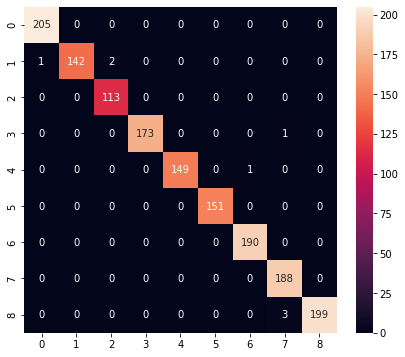

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       205
           1       1.00      0.98      0.99       145
           2       0.98      1.00      0.99       113
           3       1.00      0.99      1.00       174
           4       1.00      0.99      1.00       150
           5       1.00      1.00      1.00       151
           6       0.99      1.00      1.00       190
           7       0.98      1.00      0.99       188
           8       1.00      0.99      0.99       202

    accuracy                           0.99      1518
   macro avg       0.99      0.99      0.99      1518
weighted avg       0.99      0.99      0.99      1518



In [31]:
# Confusion matrix
def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)
print_confusion_matrix(y_test, y_pred)

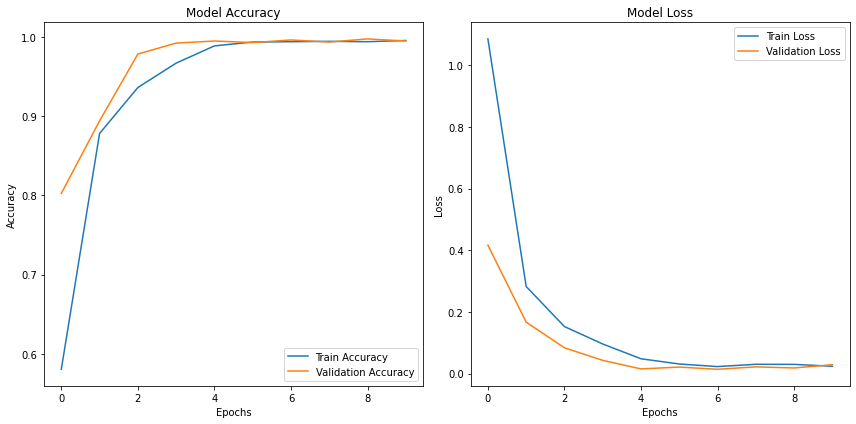

In [33]:
# Plot accuracy and loss
def plot_accuracy_loss(history):
    plt.figure(figsize=(12, 6))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_accuracy_loss(history)

# Convert to model for Tensorflow-Lite

In [34]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [35]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\saran\AppData\Local\Temp\tmplv24r1yx\assets


INFO:tensorflow:Assets written to: C:\Users\saran\AppData\Local\Temp\tmplv24r1yx\assets


Saved artifact at 'C:\Users\saran\AppData\Local\Temp\tmplv24r1yx'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42, 1), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 9), dtype=tf.float32, name=None)
Captures:
  2814613395008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2814649142432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2814654485024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2814654494176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2814654491712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2814654893040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2814654892336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2814654905008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2814654893392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2814721674752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2814654487

46914984

# Inference test

In [36]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [37]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [38]:
# Reshape the input to match the model's expected 3D shape
X_test_reshaped = np.reshape(X_test[0], (1, 42, 1))  # (1, 42, 1) -> Batch size 1, 42 keypoints, 1 channel

# Set the reshaped input tensor to the interpreter
interpreter.set_tensor(input_details[0]['index'], X_test_reshaped)


In [39]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 9 ms


In [40]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.8902345e-08 6.8217204e-08 1.8618194e-07 1.5546153e-08 9.9999952e-01
 1.3907118e-09 1.3338207e-07 1.9453950e-09 1.8057861e-10]
4
